In [1]:
import pandas as pd
import numpy as np
import json
import os
import operator
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import utils

from pathlib import Path

from sklearn.metrics import ndcg_score
from tqdm import tqdm

sns.set(rc={'figure.figsize':(24, 14)}, font_scale=2)

# Functions

In [2]:
def update_df(df, scores_path):
    '''
    Given a wikipages queries dataframe `df` and its respective NDCG `scores_path`
    update df to map the NDCG scores @k for each wikipage
    '''
    for file in os.listdir(scores_path):
        with open(scores_path + file, 'r') as f:
            scores_dict = json.load(f)

        wikipage_id_to_score = {}
        for wikipage_id in scores_dict:
            wikipage_id_to_score[int(wikipage_id)] = scores_dict[wikipage_id]['ndcg']
        
        k = file.split('_')[-1].split('.')[0]
        df['ndcg@'+k] = np.nan
        df['ndcg@'+k] = df['wikipage_id'].map(wikipage_id_to_score)

    return df

def get_query_df_dict(query_df_base_dir, score_paths_base_dir, min_tuple_width, mode, tuples_per_query_list):
    # Dictionary keyed by the number of tuples per query to the query dataframe that contains the NDCG scores at various k values
    query_df_dict = {}

    for tuples_per_query in tuples_per_query_list:
        df = pd.read_pickle(query_df_base_dir+'minTupleWidth_2_tuplesPerQuery_'+str(tuples_per_query)+'.pickle')  
        scores_path = score_paths_base_dir + 'minTupleWidth_' + str(min_tuple_width) + '_tuplesPerQuery_' + str(tuples_per_query) + '/' + mode + '/'

        query_df_dict[tuples_per_query] = update_df(df, scores_path)
    
    return query_df_dict

def get_ndcg_scores_at_k_stats(df_dict, top_k_vals, tuples_per_query_list):
    '''
    Returns the dictionaries indexed by the tuples_per_query corresponding to the mean and standard deviation of the ndcg@k scores
    '''
    mean_ndcg_scores_at_k = {}
    std_ndcg_scores_at_k = {}
    for tuples_per_query in tuples_per_query_list:
        mean_ndcg_scores_at_k[tuples_per_query] = [df_dict[tuples_per_query]['ndcg@'+str(k)].mean() for k in top_k_vals]
        std_ndcg_scores_at_k[tuples_per_query] = [df_dict[tuples_per_query]['ndcg@'+str(k)].std() for k in top_k_vals]
    return mean_ndcg_scores_at_k, std_ndcg_scores_at_k

In [77]:
def get_relevant_wikipages(wikipage_id, relevance_scores_dir):
    with open(relevance_scores_dir + str(wikipage_id) + '.json') as fp:
        relevant_wikipages = json.load(fp)
    print(relevant_wikipages)

def get_wikipage_attributes(wikipage_id, wikipage_to_attributes_dict, df):
    # Convert the wikipage_id into a wikipage name
    wikipage = df[df['wikipage_id'] == wikipage_id]['wikipage'].values[0]
    wikipage = wikipage.split('/')[-1]
    print(wikipage_to_attributes_dict[wikipage])

def get_query(wikipage_id, queries_path, k=None):
    with open(queries_path + 'wikipage_' + str(wikipage_id) + '.json') as fp:
        query_dict = json.load(fp)
    for tuple in query_dict['queries']:
        print(tuple)

def get_top_k_results(wikipage_id, scores_dir, k=10):
    with open(scores_dir + 'wikipage_' + str(wikipage_id)+'/search_output/filenameToScore.json') as fp:
        scores_dicts = json.load(fp)['scores']
    top_k_wikipages = []
    for dict in scores_dicts[:k]:
        top_k_wikipages.append(dict['pgTitle'])
    return top_k_wikipages

def get_top_k_bm25(wikipage_id, bm_25_scores_dir, table_to_wikipage_id_dict, df, k=10):
    scores_df = pd.read_csv(bm_25_scores_dir, sep="\t", index_col=False, names=["wikipage_id", "query", "table_id", "rank", "score", "field"])
    scores_df = scores_df[scores_df['wikipage_id'] == wikipage_id].sort_values(by='rank')
    top_k_wikipages = []
    for idx, row in scores_df.head(k).iterrows():
        wikipage_id = table_to_wikipage_id_dict[row['table_id']]
        wikipage = df[df['wikipage_id']==wikipage_id]['wikipage'].values[0].split('/')[-1]
        top_k_wikipages.append(wikipage)
    return top_k_wikipages   

def get_query_summary(wikipage_id, df, relevance_scores_dir, queries_path, wikipage_to_attributes_dict, scores_dir, bm_25_scores_dir, table_to_wikipage_id_dict, k=10):
    print("Query Constructed from Wikipedia Page:", df[df['wikipage_id'] == wikipage_id]['wikipage'].values[0])

    print("\nQuery Tuples:")
    get_query(wikipage_id, queries_path)

    print('\nWikipedia Categories of query Wikipage:')
    get_wikipage_attributes(wikipage_id, wikipage_to_attributes_dict, df)

    print('\nRelevant Wikipages (Ground Truth):')
    get_relevant_wikipages(wikipage_id, relevance_scores_dir)

    print("\nTop-" + str(k), "tables found using Jaccard of DBpedia Types:")
    print(get_top_k_results(wikipage_id=wikipage_id, scores_dir=scores_dir+'adjusted_jaccard/', k=k))

    print("\nTop-" + str(k), "tables found using Embeddings (Absolute Cosine):")
    print(get_top_k_results(wikipage_id=wikipage_id, scores_dir=scores_dir+'embeddings/abs_cos/', k=k))

    print("\nTop-" + str(k), "tables found using BM25 (Entity Queries):")
    print(get_top_k_bm25(wikipage_id=wikipage_id, bm_25_scores_dir=bm_25_scores_dir+'entities/content.txt', 
        table_to_wikipage_id_dict=table_to_wikipage_id_dict, df=df, k=k))

    print("\nTop-" + str(k), "tables found using BM25 (Text Queries):")
    print(get_top_k_bm25(wikipage_id=wikipage_id, bm_25_scores_dir=bm_25_scores_dir+'text/content.txt', 
        table_to_wikipage_id_dict=table_to_wikipage_id_dict, df=df, k=k))

# Search Mode: Brute Force

In [9]:
query_df_base_dir = '../../data/queries/wikipages/query_dataframes/filtered_queries/'
min_tuple_width=2
tuples_per_query_list = [1, 2, 5, 10]
top_k_vals = [5,10,15,20,50,100,150,200]

## Adjusted Jaccard of DBpedia Types

In [10]:
adj_jaccard_score_paths_base_dir = 'eval_over_search_output/wikipages_expanded/filtered_queries/adjusted_jaccard/'

# Updated Dataframes for Wikipages with Categories (Adjusted Jaccard)
query_df_adjusted_jaccard_categories = get_query_df_dict(
    query_df_base_dir=query_df_base_dir,
    score_paths_base_dir=adj_jaccard_score_paths_base_dir,
    min_tuple_width=min_tuple_width,
    mode = 'jaccard_categories',
    tuples_per_query_list=tuples_per_query_list
)

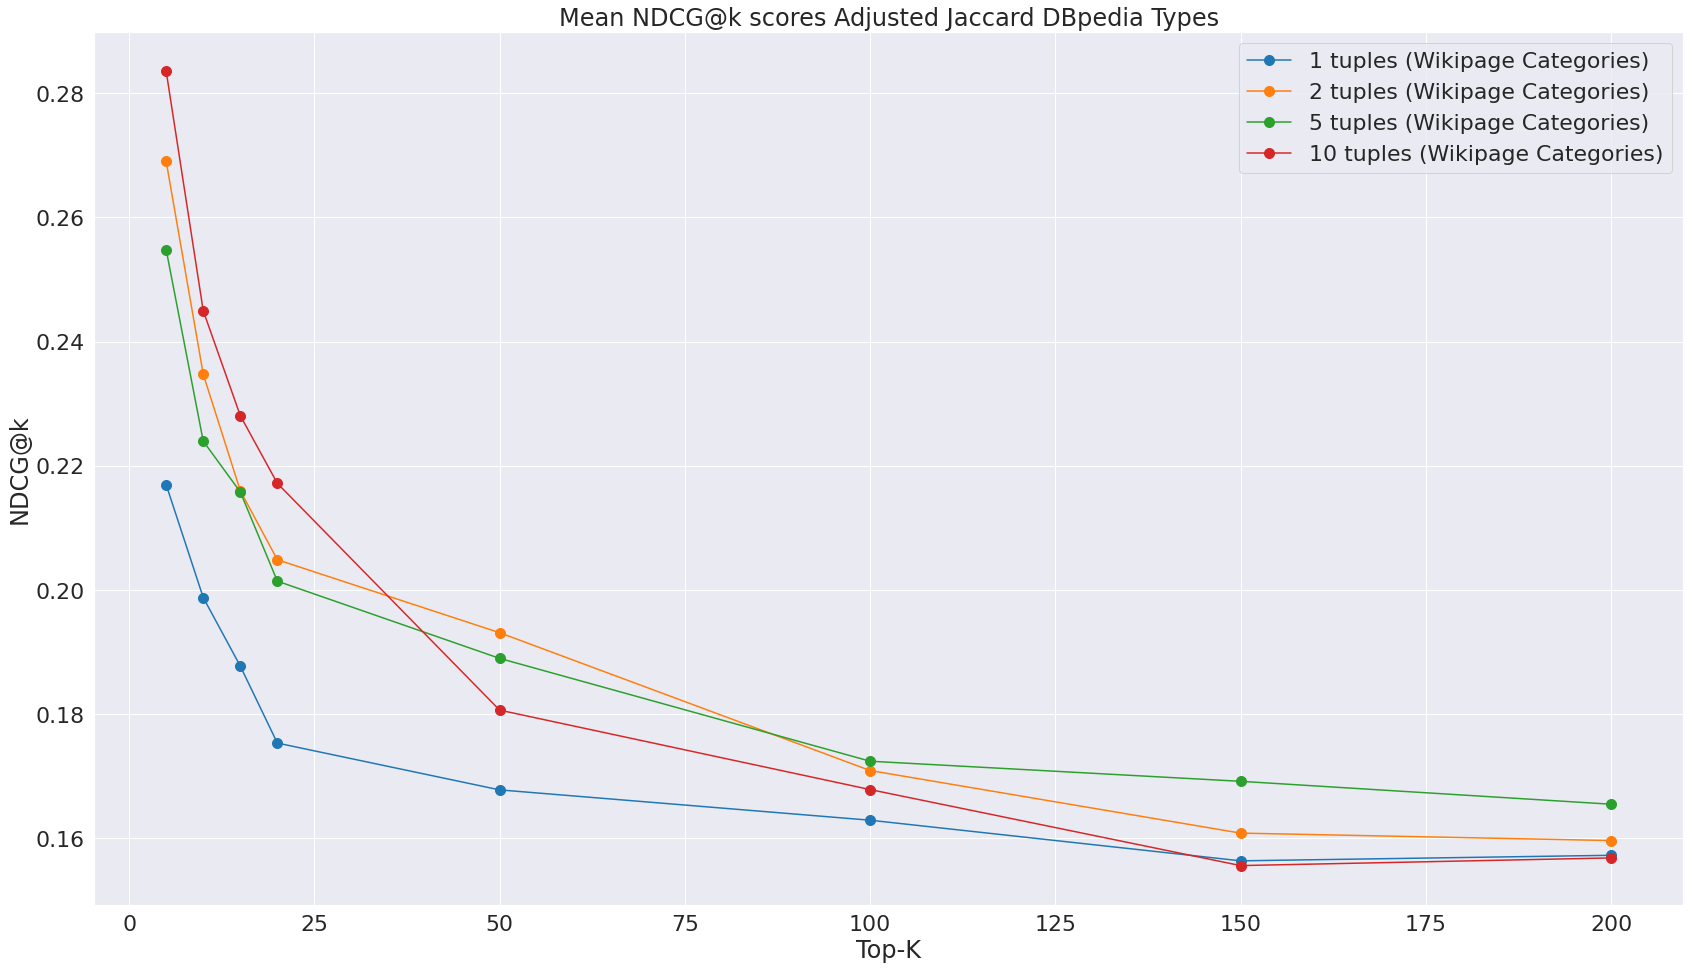

In [14]:
# Get dictionaries keyed by the tuples per query mapping to a list of the NDCG scores at the specified top-k
mean_ndcg_scores_at_k_adjusted_jaccard_categories, _ = get_ndcg_scores_at_k_stats(query_df_adjusted_jaccard_categories, top_k_vals, tuples_per_query_list)

colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
fig = plt.figure()
ax = plt.subplot(111)
for i in range(len(tuples_per_query_list)):
    plt.plot(top_k_vals, mean_ndcg_scores_at_k_adjusted_jaccard_categories[tuples_per_query_list[i]],
        marker='o', markersize=10, color=colors[i], label=str(tuples_per_query_list[i]) + ' tuples (Wikipage Categories)')

plt.legend()
ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores Adjusted Jaccard DBpedia Types');plt.tight_layout()
# plt.savefig('figures/filtered_queries/topk_ndcg@k_adjusted_jaccard_types_categories_vs_navigation_links.svg')

## Embeddings

In [95]:
scores_base_dir = 'eval_over_search_output/wikipages_expanded/filtered_queries/embeddings/'
embedding_similarity_functions=['abs_cos']

embeddings_query_dfs_dict = {}
for sim_func in embedding_similarity_functions:
    embeddings_query_dfs_dict[sim_func] = {}
    embeddings_query_dfs_dict[sim_func]['jaccard_categories'] = get_query_df_dict(
                                                                    query_df_base_dir=query_df_base_dir,
                                                                    score_paths_base_dir=scores_base_dir+sim_func+'/',
                                                                    min_tuple_width=min_tuple_width,
                                                                    mode = 'jaccard_categories',
                                                                    tuples_per_query_list=tuples_per_query_list
                                                                )

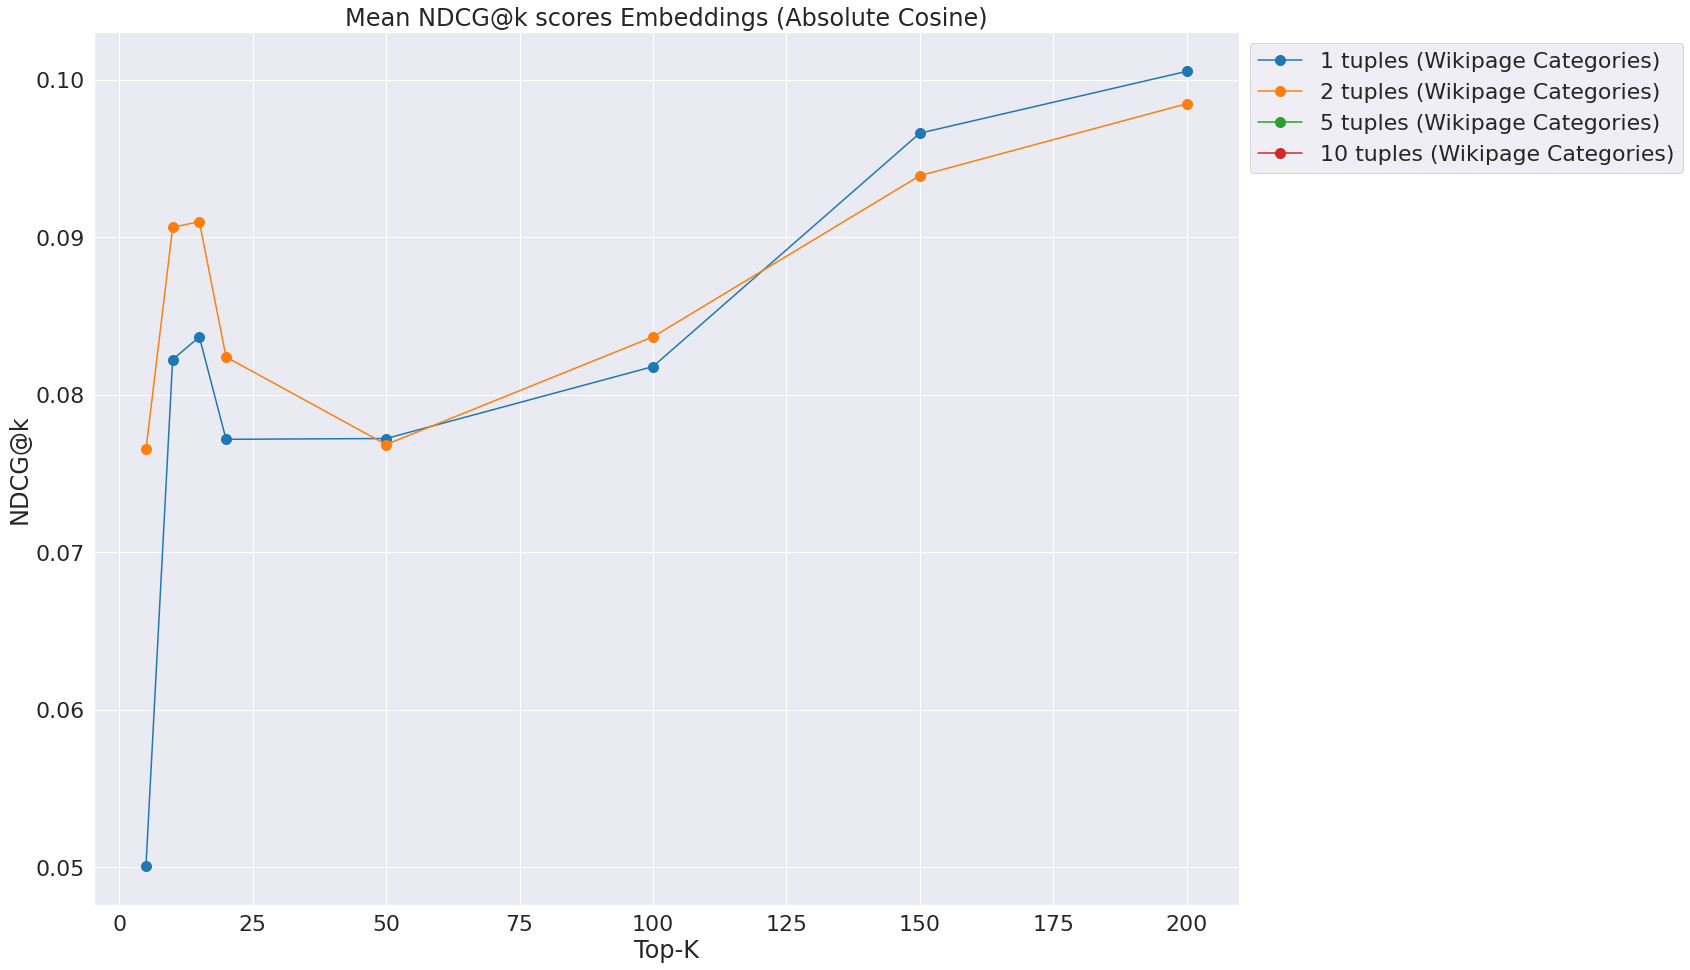

In [99]:
mean_ndcg_scores_abs_cos_jaccard_categories, _ = get_ndcg_scores_at_k_stats(embeddings_query_dfs_dict['abs_cos']['jaccard_categories'], top_k_vals, tuples_per_query_list)

fig = plt.figure();ax = plt.subplot(111)
for i in range(len(tuples_per_query_list)):
    plt.plot(top_k_vals, mean_ndcg_scores_abs_cos_jaccard_categories[tuples_per_query_list[i]],
        marker='o', markersize=10, color=colors[i], label=str(tuples_per_query_list[i]) + ' tuples (Wikipage Categories)')

plt.legend()
ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores Embeddings (Absolute Cosine)');plt.tight_layout()
# plt.savefig('figures/filtered_queries/topk_ndcg@k_embeddings_vs_adjusted_jaccard_types_normalized_cosine_jaccard_categories.svg')

# Search Mode: BM25 

In [90]:
with open('evaluation_dataframes/wikipages_expanded_filtered_queries_bm25_dfs_dict.pickle', 'rb') as handle:
    dfs_dict = pickle.load(handle)

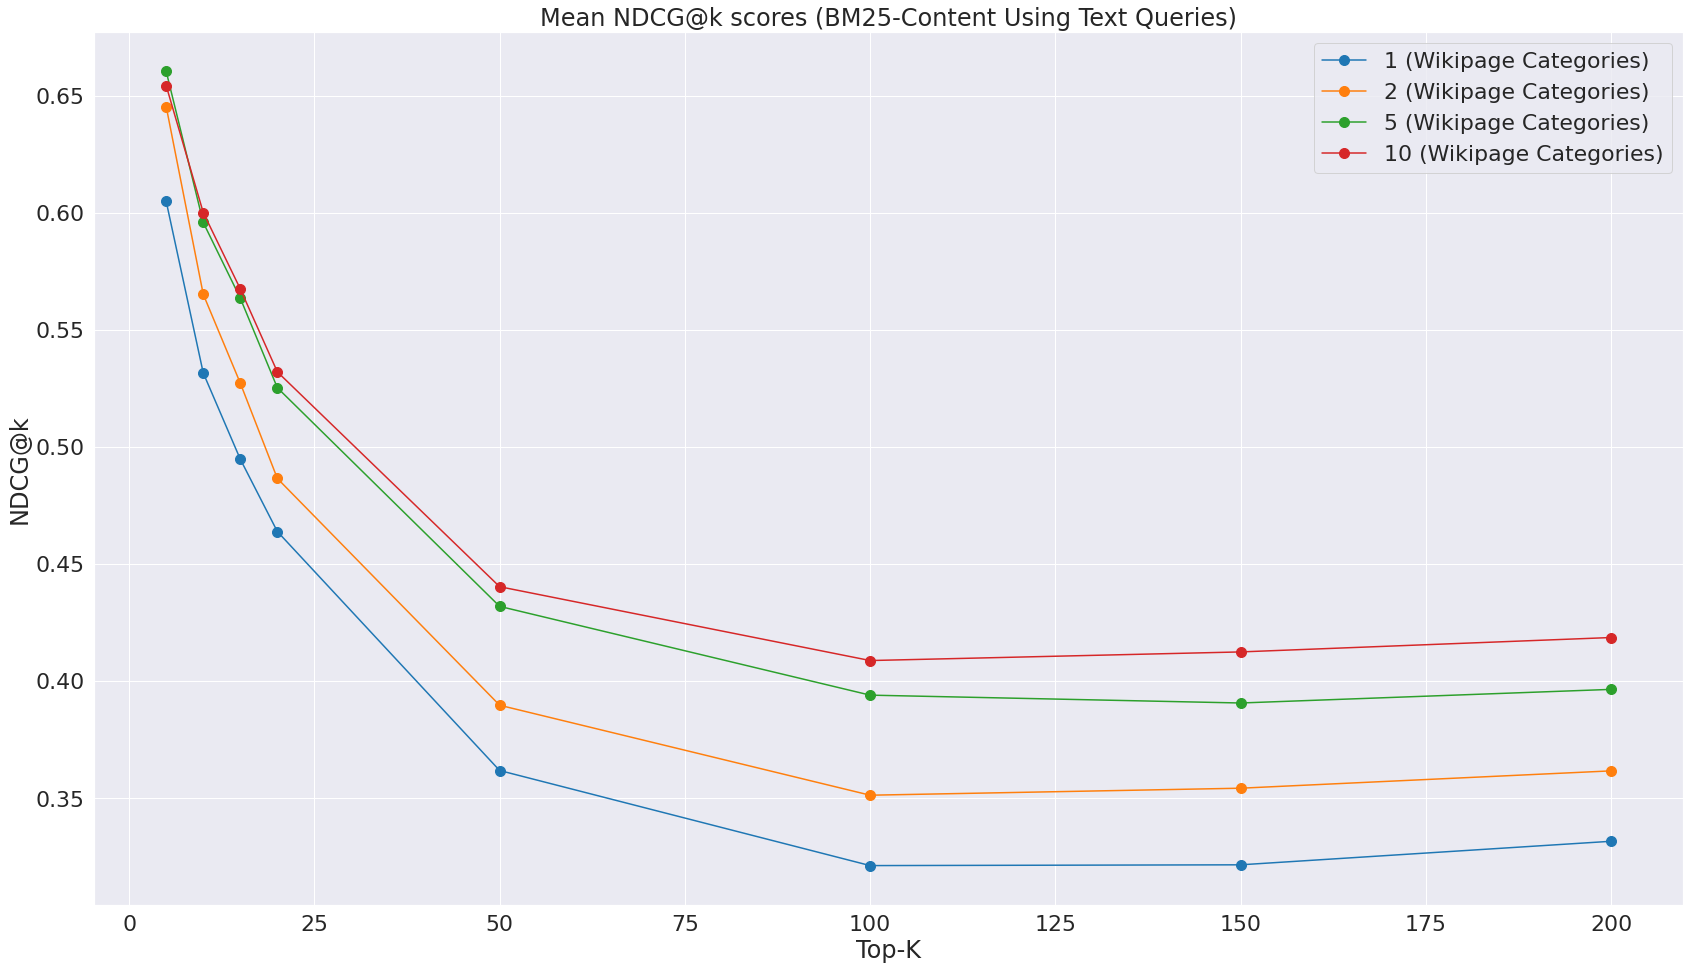

In [91]:
colors = ['tab:blue', 'tab:orange','tab:green', 'tab:red', 'tab:purple', 'tab:brown']
fig = plt.figure()
ax = plt.subplot(111)
for i in range(len(tuples_per_query_list)):
    mean_ndcg_scores_at_k_categories = [dfs_dict[tuples_per_query_list[i]]['text']['content_categories']['ndcg@'+str(k)].mean() for k in top_k_vals]

    plt.plot(top_k_vals, mean_ndcg_scores_at_k_categories, marker='o', markersize=10, label=str(tuples_per_query_list[i]) + ' (Wikipage Categories)', color=colors[i])

ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores (BM25-Content Using Text Queries)');plt.tight_layout()
# plt.savefig('figures/filtered_queries/expanded_wikipages_dataset_topk_ndcg@k_bm25_text_queries_categories_vs_navigation_links.svg')

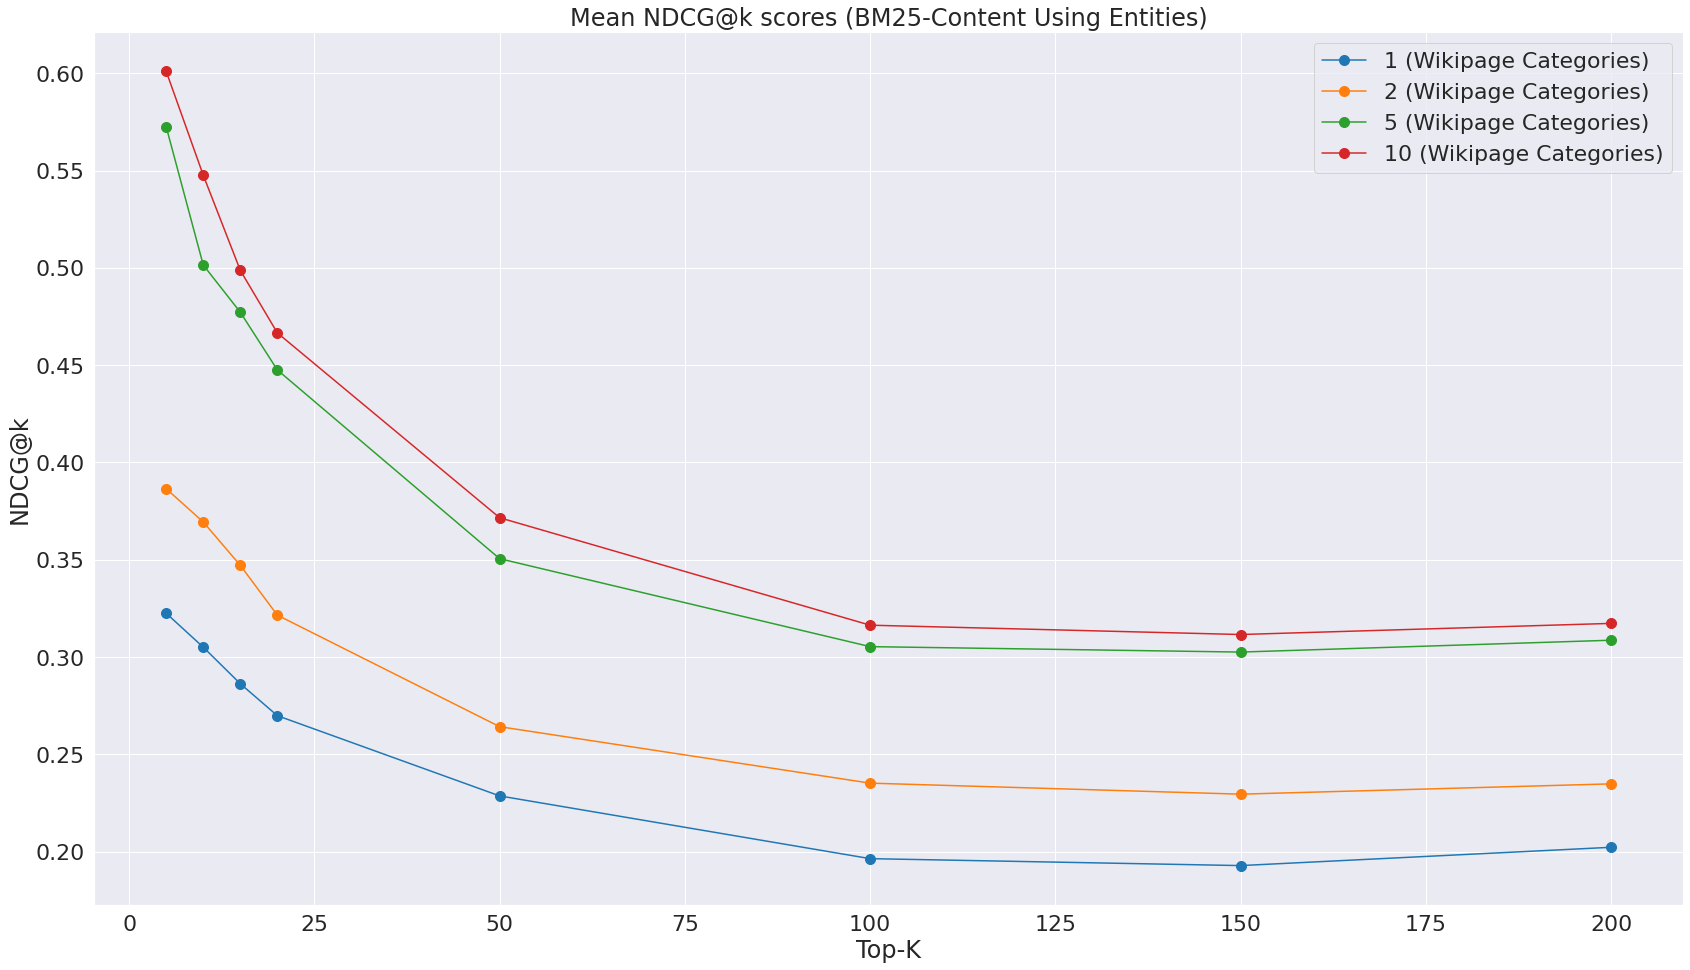

In [92]:
colors = ['tab:blue', 'tab:orange','tab:green', 'tab:red', 'tab:purple', 'tab:brown']
fig = plt.figure()
ax = plt.subplot(111)
for i in range(len(tuples_per_query_list)):
    mean_ndcg_scores_at_k_categories = [dfs_dict[tuples_per_query_list[i]]['entities']['content_categories']['ndcg@'+str(k)].mean() for k in top_k_vals]

    plt.plot(top_k_vals, mean_ndcg_scores_at_k_categories, marker='o', markersize=10, label=str(tuples_per_query_list[i]) + ' (Wikipage Categories)', color=colors[i])

ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores (BM25-Content Using Entities)');plt.tight_layout()

# Comparison across different methods

In [104]:
embeddings_eval_df_dict = {}
embeddings_eval_df = pd.DataFrame(columns=['mode', 'top-k', 'ndcg_score', 'wikipage_id', 'tuples_per_query'])

for sim_func in embedding_similarity_functions:
    for tuples_per_query in tuples_per_query_list:
        df_tmp = embeddings_query_dfs_dict[sim_func]['jaccard_categories'][tuples_per_query]
        for _, row in df_tmp.iterrows():
            for k in top_k_vals:
                row_to_append = [sim_func, k, row['ndcg@'+str(k)], row['wikipage_id'], tuples_per_query]
                embeddings_eval_df.loc[len(embeddings_eval_df.index)] = row_to_append

# Add Jaccard Of Types in the dataframe for comparison
for tuples_per_query in tuples_per_query_list:
    df_tmp = query_df_adjusted_jaccard_categories[tuples_per_query]
    for _, row in df_tmp.iterrows():
        for k in top_k_vals:
            row_to_append = ['jaccard_types', k, row['ndcg@'+str(k)], row['wikipage_id'], tuples_per_query]
            embeddings_eval_df.loc[len(embeddings_eval_df.index)] = row_to_append

# Add BM25 scores in the dataframe fro comparison
for tuples_per_query in tuples_per_query_list:
    bm25_text = dfs_dict[tuples_per_query_list[i]]['text']['content_categories']
    bm25_entities = dfs_dict[tuples_per_query_list[i]]['entities']['content_categories']

    for _, row in bm25_text.iterrows():
        for k in top_k_vals:
            row_to_append = ['bm25_text_queries', k, row['ndcg@'+str(k)], row['wikipage_id'], tuples_per_query]
            embeddings_eval_df.loc[len(embeddings_eval_df.index)] = row_to_append

    for _, row in bm25_entities.iterrows():
        for k in top_k_vals:
            row_to_append = ['bm25_entity_queries', k, row['ndcg@'+str(k)], row['wikipage_id'], tuples_per_query]
            embeddings_eval_df.loc[len(embeddings_eval_df.index)] = row_to_append

embeddings_eval_df

,mode,top-k,ndcg_score,wikipage_id,tuples_per_query
0,abs_cos,5,0.000000,32,1
1,abs_cos,10,0.000000,32,1
2,abs_cos,15,0.000000,32,1
3,abs_cos,20,0.018813,32,1
4,abs_cos,50,0.022282,32,1
...,...,...,...,...,...
1275,bm25_entity_queries,20,0.382838,156636,10
1276,bm25_entity_queries,50,0.268237,156636,10
1277,bm25_entity_queries,100,0.229993,156636,10
1278,bm25_entity_queries,150,0.210560,156636,10


In [108]:
embeddings_eval_df[(embeddings_eval_df['wikipage_id']==32) & (embeddings_eval_df['top-k']==10) & (embeddings_eval_df['tuples_per_query']==2)]

,mode,top-k,ndcg_score,wikipage_id,tuples_per_query
81,abs_cos,10,0.000000,32,2
401,jaccard_types,10,0.068564,32,2
801,bm25_text_queries,10,0.651373,32,2
881,bm25_entity_queries,10,0.633587,32,2


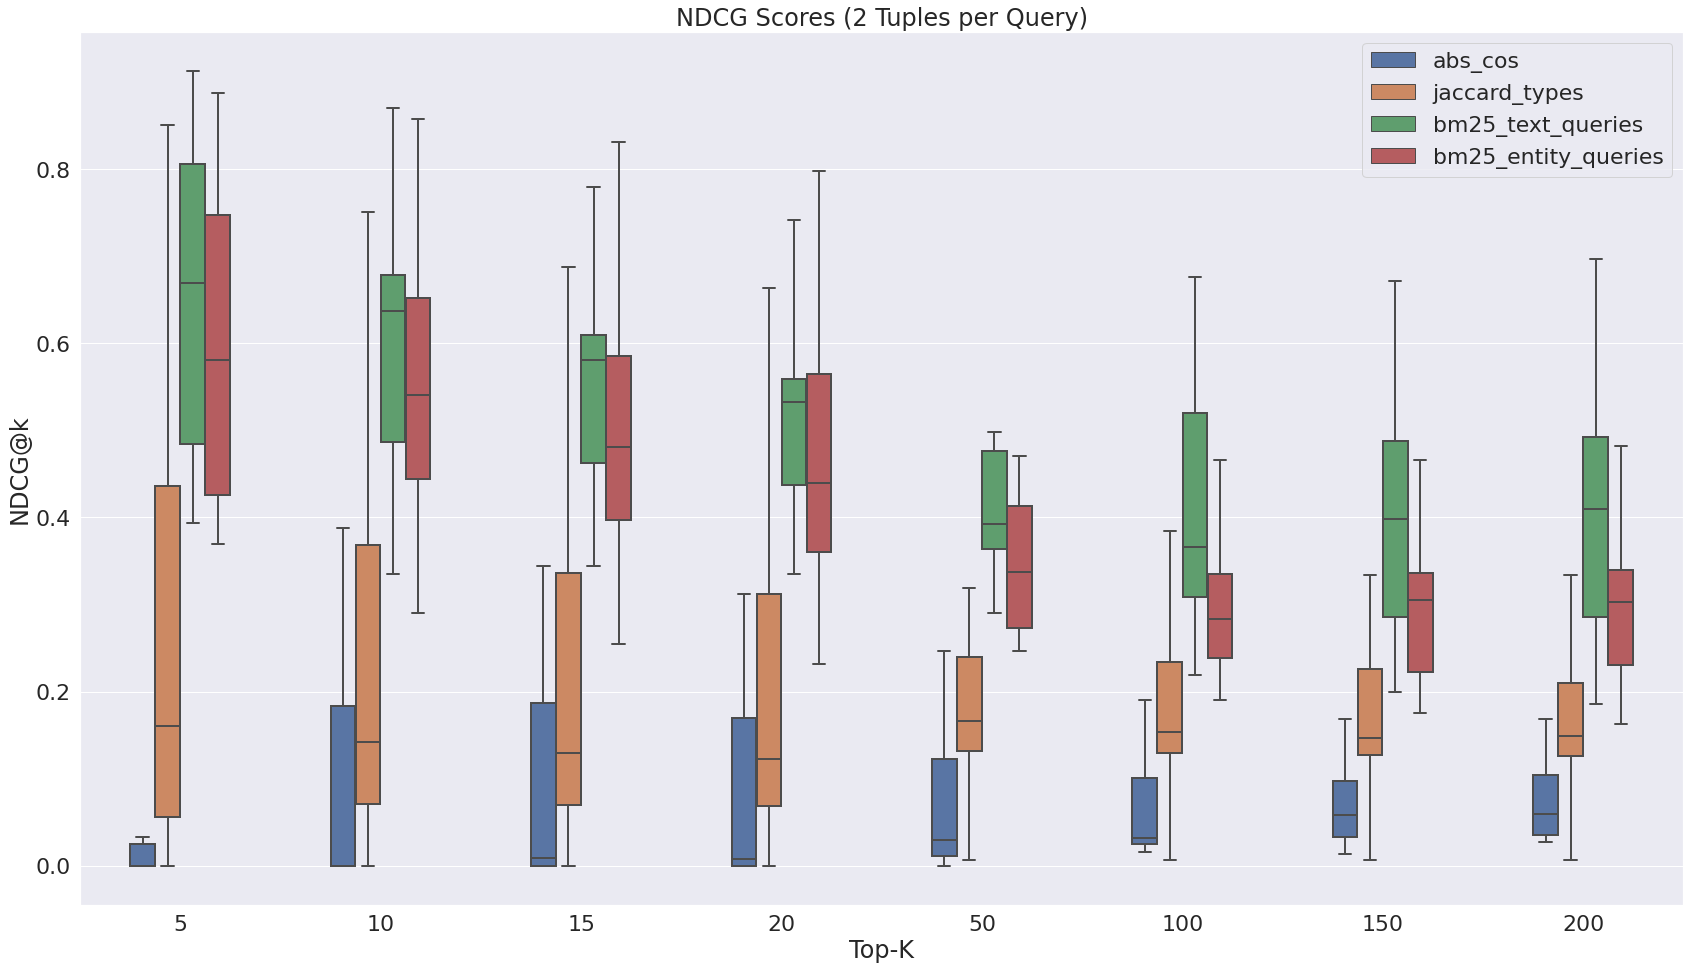

In [105]:
ax = sns.boxplot(x="top-k", y="ndcg_score", hue="mode", data=embeddings_eval_df[embeddings_eval_df['tuples_per_query']==2], showfliers=False, width=0.5, linewidth=2)
plt.xlabel("Top-K");plt.ylabel("NDCG@k");plt.title("NDCG Scores (2 Tuples per Query)");plt.legend(loc='upper right');plt.tight_layout()

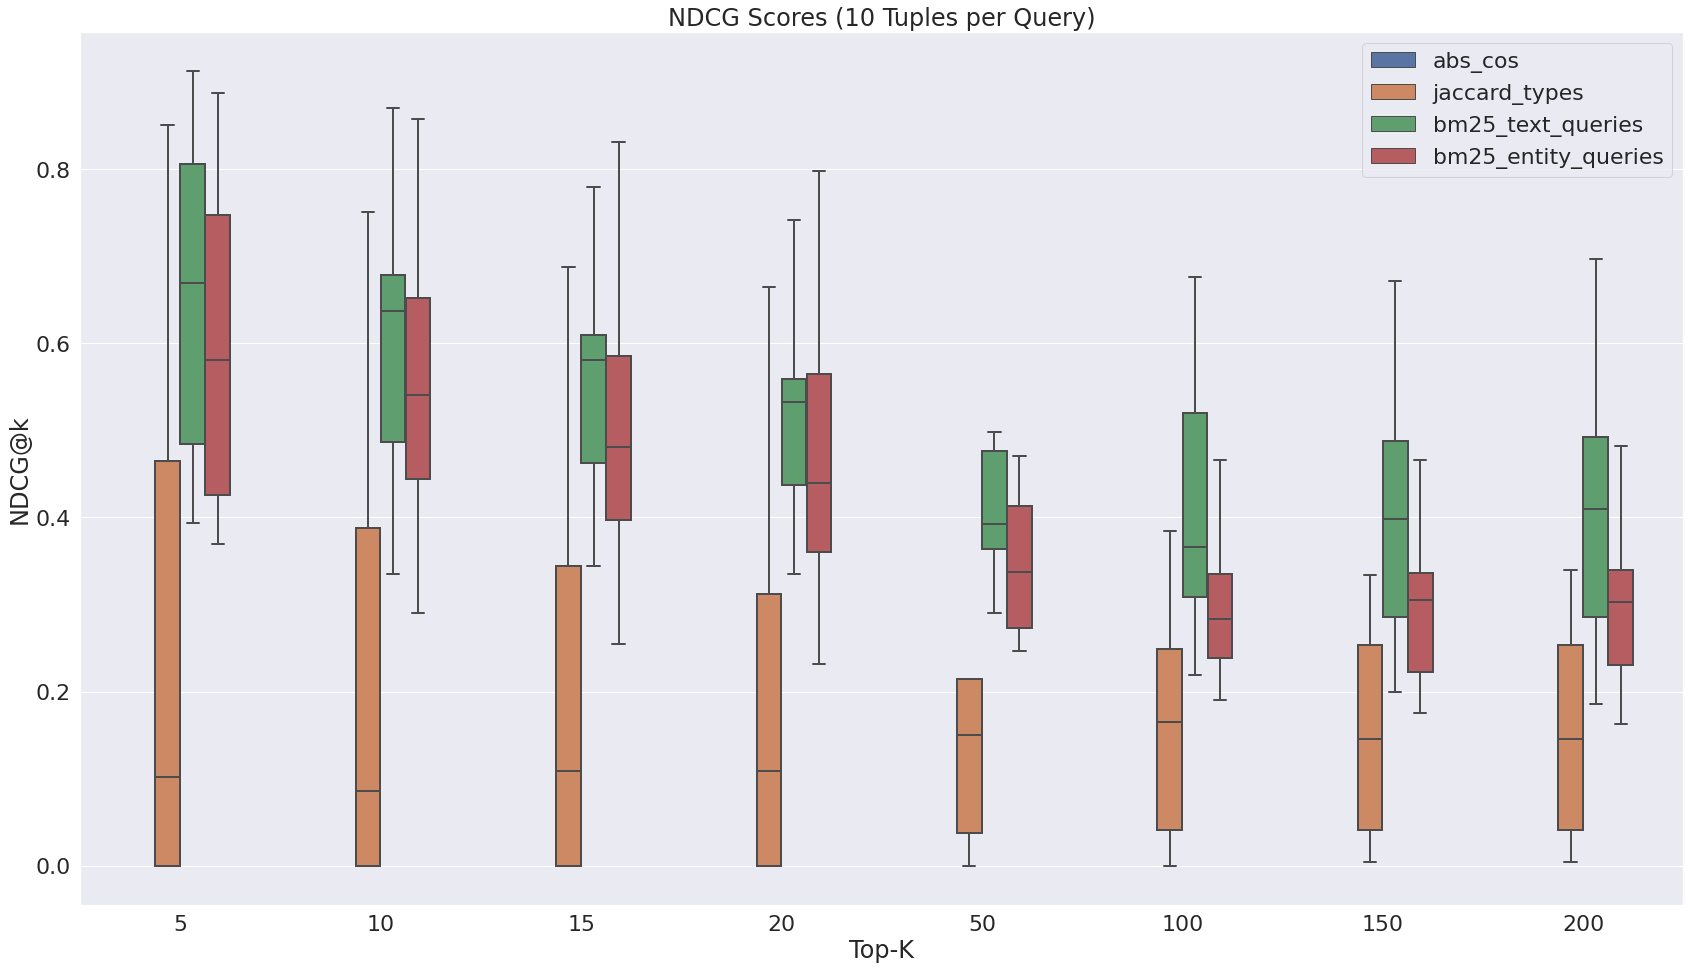

In [106]:
ax = sns.boxplot(x="top-k", y="ndcg_score", hue="mode", data=embeddings_eval_df[embeddings_eval_df['tuples_per_query']==10], showfliers=False, width=0.5, linewidth=2)
plt.xlabel("Top-K");plt.ylabel("NDCG@k");plt.title("NDCG Scores (10 Tuples per Query)");plt.legend(loc='upper right');plt.tight_layout()

# Exploration of output for each Query

In [36]:
queries_df = pd.read_pickle('../../data/queries/wikipages/query_dataframes/expanded_wikipages/filtered_queries/filtered_queries.pickle')
queries_df

,wikipage,wikipage_id,num_tables,tables,num_entities,tuple_width,num_tuples,selected_table,selected_row_ids,categories_relevant_wikipages,categories_relevant_tables,navigation_links_relevant_wikipages,navigation_links_relevant_tables,categories_expansion_ratio,navigation_links_expansion_ratio,avg_query_containment
32,https://en.wikipedia.org/wiki/Andre_Norton_Award,32,1,[table-0001-242.json],[80],4.0,11.0,table-0001-242.json,"[4, 6, 7, 10, 13, 14, 28, 30, 31, 33, 36]",51.0,58.0,NaN,NaN,58.0,NaN,0.036120
1119,https://en.wikipedia.org/wiki/List_of_Norwegia...,1119,1,[table-0007-748.json],[40],3.0,12.0,table-0007-748.json,"[0, 2, 3, 4, 6, 8, 10, 12, 13, 14, 16, 17]",55.0,100.0,NaN,NaN,100.0,NaN,0.024691
1523,https://en.wikipedia.org/wiki/Un_Certain_Regard,1523,1,[table-0010-283.json],[103],4.0,19.0,table-0010-283.json,"[3, 4, 5, 6, 8, 11, 12, 13, 14, 16, 21, 23, 24...",96.0,186.0,NaN,NaN,186.0,NaN,0.013601
7003,https://en.wikipedia.org/wiki/List_of_United_S...,7003,1,[table-0047-348.json],[243],4.0,27.0,table-0047-348.json,"[4, 6, 9, 16, 19, 20, 25, 33, 37, 38, 42, 62, ...",57.0,124.0,NaN,NaN,124.0,NaN,0.010958
20072,https://en.wikipedia.org/wiki/List_of_demolish...,20072,1,[table-0142-322.json],[54],3.0,10.0,table-0142-322.json,"[2, 4, 7, 8, 10, 18, 20, 21, 23, 25]",59.0,142.0,NaN,NaN,142.0,NaN,0.009878
23272,https://en.wikipedia.org/wiki/List_of_football...,23272,1,[table-0166-87.json],[177],4.0,23.0,table-0166-87.json,"[0, 4, 12, 13, 16, 17, 24, 25, 28, 30, 35, 41,...",87.0,104.0,NaN,NaN,104.0,NaN,0.009335
40352,https://en.wikipedia.org/wiki/List_of_Dreamcas...,40352,2,"[table-0283-433.json, table-0283-434.json]","[470, 22]",4.0,156.0,table-0283-433.json,"[0, 1, 2, 4, 18, 19, 26, 27, 51, 56, 60, 62, 6...",84.0,227.0,NaN,NaN,113.5,NaN,0.029280
52690,https://en.wikipedia.org/wiki/List_of_Prime_Mi...,52690,1,[table-0365-306.json],[55],3.0,22.0,table-0365-306.json,"[14, 15, 19, 33, 34, 36, 37, 51, 52, 59, 60, 6...",91.0,113.0,NaN,NaN,113.0,NaN,0.006975
56122,https://en.wikipedia.org/wiki/Highest_mountain...,56122,1,[table-0388-485.json],[56],3.0,22.0,table-0388-485.json,"[3, 5, 6, 12, 13, 16, 17, 19, 27, 28, 32, 34, ...",68.0,111.0,NaN,NaN,111.0,NaN,0.009773
156636,https://en.wikipedia.org/wiki/List_of_prefectu...,156636,1,[table-1068-761.json],[348],3.0,306.0,table-1068-761.json,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15,...",81.0,150.0,NaN,NaN,150.0,NaN,0.017717


## 2 Tuples Per Query

In [78]:
df = pd.read_pickle('../../data/tables/wikipages/wikipages_expanded_dataset/wikipages_df.pickle')

# Construct a dictionary that maps each table name to its respective wikipage_id
table_to_wikipage_id_dict = {}
for _, row in tqdm(df.iterrows(), total=len(df.index)):
    for table in row['tables']:
        table_to_wikipage_id_dict[table] = row['wikipage_id']

relevance_scores_dir = '../../data/queries/wikipages/groundtruth_generation/wikipage_relevance_scores/wikipages_expanded_dataset/jaccard_categories_new/'
wikipage_to_categories_path = '../../data/queries/wikipages/groundtruth_generation/wikipage_relevance_scores/wikipages_expanded_dataset/wikipage_to_categories.json'
with open(wikipage_to_categories_path) as fp:
    wikipage_to_categories_dict = json.load(fp)


queries_path='../../data/queries/wikipages/queries/expanded_wikipages/filtered_queries/minTupleWidth_2_tuplesPerQuery_2/'
scores_dir = '../../data/search/expanded_wikipages/filtered_queries/minTupleWidth_2_tuplesPerQuery_2/'
bm_25_scores_dir = '../../Web-Table-Retrieval-Benchmark/data/wikipages_expanded/ranking/filtered_queries/minTupleWidth_2_tuplesPerQuery_2/'

100%|██████████| 149526/149526 [00:05<00:00, 29165.22it/s]


### Wikipage_ID 32 (Andre Norton Award)

In [109]:
embeddings_eval_df[(embeddings_eval_df['wikipage_id']==32) & (embeddings_eval_df['top-k']==10) & (embeddings_eval_df['tuples_per_query']==2)]

,mode,top-k,ndcg_score,wikipage_id,tuples_per_query
81,abs_cos,10,0.000000,32,2
401,jaccard_types,10,0.068564,32,2
801,bm25_text_queries,10,0.651373,32,2
881,bm25_entity_queries,10,0.633587,32,2


In [79]:
get_query_summary(
    wikipage_id=32, df=df, relevance_scores_dir=relevance_scores_dir, scores_dir=scores_dir, bm_25_scores_dir=bm_25_scores_dir,
    queries_path=queries_path, wikipage_to_attributes_dict=wikipage_to_categories_dict,
    table_to_wikipage_id_dict=table_to_wikipage_id_dict, k=10
)

Query Constructed from Wikipedia Page: https://en.wikipedia.org/wiki/Andre_Norton_Award

Query Tuples:
['http://dbpedia.org/resource/2006_in_literature', 'http://dbpedia.org/resource/Justine_Larbalestier', 'http://dbpedia.org/resource/Magic_or_Madness', 'http://dbpedia.org/resource/Penguin_Group']
['http://dbpedia.org/resource/2006_in_literature', 'http://dbpedia.org/resource/Megan_Whalen_Turner', 'http://dbpedia.org/resource/The_King_of_Attolia', 'http://dbpedia.org/resource/HarperCollins']

Wikipedia Categories of query Wikipage:
['2005 Establishments In The United States', "American Children'S Literary Awards", 'American Speculative Fiction Awards', 'Awards Established In 2005', 'Fantasy Awards', 'Science Fiction Awards']

Relevant Wikipages (Ground Truth):
{'Andre_Norton_Award': 1.0, 'List_of_James_Tiptree,_Jr._Award_winners': 0.3, 'Dwarf_Stars_Award': 0.2857142857142857, 'John_W._Campbell_Award_for_Best_New_Writer': 0.2727272727272727, 'Hugo_Award': 0.2222222222222222, 'NWA_Hall_o

### Wikipage_ID 1119 (Norwegian Consorts)

In [110]:
embeddings_eval_df[(embeddings_eval_df['wikipage_id']==1119) & (embeddings_eval_df['top-k']==10) & (embeddings_eval_df['tuples_per_query']==2)]

,mode,top-k,ndcg_score,wikipage_id,tuples_per_query
89,abs_cos,10,0.245249,1119,2
409,jaccard_types,10,0.000000,1119,2
809,bm25_text_queries,10,0.465238,1119,2
889,bm25_entity_queries,10,0.463634,1119,2


In [88]:
get_query_summary(
    wikipage_id=1119, df=df, relevance_scores_dir=relevance_scores_dir, scores_dir=scores_dir, bm_25_scores_dir=bm_25_scores_dir,
    queries_path=queries_path, wikipage_to_attributes_dict=wikipage_to_categories_dict,
    table_to_wikipage_id_dict=table_to_wikipage_id_dict, k=10
)

Query Constructed from Wikipedia Page: https://en.wikipedia.org/wiki/List_of_Norwegian_consorts

Query Tuples:
['http://dbpedia.org/resource/Dorothea_of_Brandenburg', 'http://dbpedia.org/resource/John,_Margrave_of_Brandenburg-Kulmbach', 'http://dbpedia.org/resource/Christian_I_of_Denmark']
['http://dbpedia.org/resource/Christina_of_Saxony', 'http://dbpedia.org/resource/Ernest,_Elector_of_Saxony', 'http://dbpedia.org/resource/John,_King_of_Denmark']

Wikipedia Categories of query Wikipage:
['Lists Of Norwegian People', 'Lists Of Queens', 'Lists Of Royal Consorts', 'Lists Of Women', 'Norwegian Royal Consorts']

Relevant Wikipages (Ground Truth):
{'List_of_Norwegian_consorts': 1.0, 'List_of_Swedish_consorts': 0.375, 'List_of_Bulgarian_consorts': 0.3333333333333333, 'List_of_English_consorts': 0.3333333333333333, 'List_of_Portuguese_consorts': 0.3333333333333333, 'List_of_Navarrese_consorts': 0.3333333333333333, 'List_of_Hungarian_consorts': 0.2857142857142857, 'List_of_Georgian_consorts':

### Wikipage_ID 1523 (Un Certain Regard)

In [111]:
embeddings_eval_df[(embeddings_eval_df['wikipage_id']==1523) & (embeddings_eval_df['top-k']==10) & (embeddings_eval_df['tuples_per_query']==2)]

,mode,top-k,ndcg_score,wikipage_id,tuples_per_query
97,abs_cos,10,0.000000,1523,2
417,jaccard_types,10,0.178160,1523,2
817,bm25_text_queries,10,0.373687,1523,2
897,bm25_entity_queries,10,0.290310,1523,2


In [89]:
get_query_summary(
    wikipage_id=1523, df=df, relevance_scores_dir=relevance_scores_dir, scores_dir=scores_dir, bm_25_scores_dir=bm_25_scores_dir,
    queries_path=queries_path, wikipage_to_attributes_dict=wikipage_to_categories_dict,
    table_to_wikipage_id_dict=table_to_wikipage_id_dict, k=10
)

Query Constructed from Wikipedia Page: https://en.wikipedia.org/wiki/Un_Certain_Regard

Query Tuples:
['http://dbpedia.org/resource/2000_Cannes_Film_Festival', 'http://dbpedia.org/resource/Me_You_Them', 'http://dbpedia.org/resource/Andrucha_Waddington', 'http://dbpedia.org/resource/Brazil']
['http://dbpedia.org/resource/2001_Cannes_Film_Festival', 'http://dbpedia.org/resource/Boyhood_Loves', 'http://dbpedia.org/resource/Yves_Caumon', 'http://dbpedia.org/resource/France']

Wikipedia Categories of query Wikipage:
['Cannes Film Festival', 'Lists Of Films By Award']

Relevant Wikipages (Ground Truth):
{'Un_Certain_Regard': 1.0, 'Jury_Prize_(Cannes_Film_Festival)': 1.0, 'Cinéfondation': 1.0, 'Grand_Prix_(Cannes_Film_Festival)': 0.6666666666666666, 'Best_Director_Award_(Cannes_Film_Festival)': 0.5, 'Best_Screenplay_Award_(Cannes_Film_Festival)': 0.5, 'Vulcan_Award': 0.5, "Caméra_d'Or": 0.4, 'Prize_of_the_Ecumenical_Jury': 0.4, 'Best_Actress_Award_(Cannes_Film_Festival)': 0.3333333333333333, 

### Wikipage_ID 7003 (List of United States Air Force Four-Star Generals)

In [112]:
embeddings_eval_df[(embeddings_eval_df['wikipage_id']==7003) & (embeddings_eval_df['top-k']==10) & (embeddings_eval_df['tuples_per_query']==2)]

,mode,top-k,ndcg_score,wikipage_id,tuples_per_query
105,abs_cos,10,0.000000,7003,2
425,jaccard_types,10,0.466836,7003,2
825,bm25_text_queries,10,0.784767,7003,2
905,bm25_entity_queries,10,0.731349,7003,2


In [93]:
get_query_summary(
    wikipage_id=7003, df=df, relevance_scores_dir=relevance_scores_dir, scores_dir=scores_dir, bm_25_scores_dir=bm_25_scores_dir,
    queries_path=queries_path, wikipage_to_attributes_dict=wikipage_to_categories_dict,
    table_to_wikipage_id_dict=table_to_wikipage_id_dict, k=10
)

Query Constructed from Wikipedia Page: https://en.wikipedia.org/wiki/List_of_United_States_Air_Force_four-star_generals

Query Tuples:
['http://dbpedia.org/resource/Hoyt_Vandenberg', 'http://dbpedia.org/resource/Vice_Chief_of_Staff_of_the_United_States_Air_Force', 'http://dbpedia.org/resource/United_States_Military_Academy', 'http://dbpedia.org/resource/Director_of_Central_Intelligence']
['http://dbpedia.org/resource/Nathan_Farragut_Twining', 'http://dbpedia.org/resource/Vice_Chief_of_Staff_of_the_United_States_Air_Force', 'http://dbpedia.org/resource/United_States_Military_Academy', 'http://dbpedia.org/resource/List_of_United_States_Marine_Corps_four-star_generals']

Wikipedia Categories of query Wikipage:
['Four-Star Officers', 'Lists Of American Military Personnel', 'Lists Of Generals', 'United States Air Force Generals', 'United States Air Force Lists']

Relevant Wikipages (Ground Truth):
{'List_of_United_States_Air_Force_four-star_generals': 1.0, 'List_of_lieutenant_generals_in_th

### Wikipage_ID 20072 (List of Demolished Churches in the City of London)

In [114]:
embeddings_eval_df[(embeddings_eval_df['wikipage_id']==20072) & (embeddings_eval_df['top-k']==10) & (embeddings_eval_df['tuples_per_query']==2)]

,mode,top-k,ndcg_score,wikipage_id,tuples_per_query
113,abs_cos,10,0.000000,20072,2
433,jaccard_types,10,0.751293,20072,2
833,bm25_text_queries,10,0.870875,20072,2
913,bm25_entity_queries,10,0.858211,20072,2


In [94]:
get_query_summary(
    wikipage_id=20072, df=df, relevance_scores_dir=relevance_scores_dir, scores_dir=scores_dir, bm_25_scores_dir=bm_25_scores_dir,
    queries_path=queries_path, wikipage_to_attributes_dict=wikipage_to_categories_dict,
    table_to_wikipage_id_dict=table_to_wikipage_id_dict, k=10
)

Query Constructed from Wikipedia Page: https://en.wikipedia.org/wiki/List_of_demolished_churches_in_the_City_of_London

Query Tuples:
['http://dbpedia.org/resource/All-Hallows-the-Great', 'http://dbpedia.org/resource/Thames_Street,_London', 'http://dbpedia.org/resource/St_Michael_Paternoster_Royal']
['http://dbpedia.org/resource/St_Alphege_London_Wall', 'http://dbpedia.org/resource/London_Wall', 'http://dbpedia.org/resource/St_Mary_Aldermanbury']

Wikipedia Categories of query Wikipage:
['Churches Rebuilt After The Great Fire Of London But Since Demolished', 'City Of London-Related Lists', 'Destroyed Churches In London', 'Lists Of Buildings And Structures In London', 'Lists Of Churches In England', 'Lists Of Demolished Buildings And Structures', 'London Religion-Related Lists']

Relevant Wikipages (Ground Truth):
{'List_of_demolished_churches_in_the_City_of_London': 1.0, 'List_of_churches_destroyed_in_the_Great_Fire_of_London_and_not_rebuilt': 0.4444444444444444, 'List_of_Christopher_W

### Wikipage_ID 23272 (List of Football Stadiums in Spain)

In [116]:
embeddings_eval_df[(embeddings_eval_df['wikipage_id']==23272) & (embeddings_eval_df['top-k']==10) & (embeddings_eval_df['tuples_per_query']==2)]

,mode,top-k,ndcg_score,wikipage_id,tuples_per_query
121,abs_cos,10,0.000000,23272,2
441,jaccard_types,10,0.105056,23272,2
841,bm25_text_queries,10,0.658436,23272,2
921,bm25_entity_queries,10,0.658436,23272,2


In [115]:
get_query_summary(
    wikipage_id=23272, df=df, relevance_scores_dir=relevance_scores_dir, scores_dir=scores_dir, bm_25_scores_dir=bm_25_scores_dir,
    queries_path=queries_path, wikipage_to_attributes_dict=wikipage_to_categories_dict,
    table_to_wikipage_id_dict=table_to_wikipage_id_dict, k=10
)

Query Constructed from Wikipedia Page: https://en.wikipedia.org/wiki/List_of_football_stadiums_in_Spain

Query Tuples:
['http://dbpedia.org/resource/Camp_Nou', 'http://dbpedia.org/resource/Barcelona', 'http://dbpedia.org/resource/Catalonia', 'http://dbpedia.org/resource/FC_Barcelona']
['http://dbpedia.org/resource/Mestalla_Stadium', 'http://dbpedia.org/resource/Valencia', 'http://dbpedia.org/resource/Valencian_Community', 'http://dbpedia.org/resource/Valencia_CF']

Wikipedia Categories of query Wikipage:
['Association Football In Spain Lists', 'Football Venues In Spain', 'Lists Of Association Football Stadiums', 'Lists Of Buildings And Structures In Spain', 'Lists Of Stadiums By Country']

Relevant Wikipages (Ground Truth):
{'List_of_football_stadiums_in_Spain': 1.0, 'List_of_football_stadiums_in_Albania': 0.25, 'List_of_stadiums_in_India': 0.16666666666666666, 'List_of_stadiums_in_South_Africa': 0.16666666666666666, 'List_of_stadiums_in_New_Zealand': 0.16666666666666666, 'CONCACAF_Cha

### Wikipage_ID 40352 (List of Dreamcast Games)

In [118]:
embeddings_eval_df[(embeddings_eval_df['wikipage_id']==40352) & (embeddings_eval_df['top-k']==10) & (embeddings_eval_df['tuples_per_query']==2)]

,mode,top-k,ndcg_score,wikipage_id,tuples_per_query
129,abs_cos,10,0.000000,40352,2
449,jaccard_types,10,0.309647,40352,2
849,bm25_text_queries,10,0.335432,40352,2
929,bm25_entity_queries,10,0.320996,40352,2


In [117]:
get_query_summary(
    wikipage_id=40352, df=df, relevance_scores_dir=relevance_scores_dir, scores_dir=scores_dir, bm_25_scores_dir=bm_25_scores_dir,
    queries_path=queries_path, wikipage_to_attributes_dict=wikipage_to_categories_dict,
    table_to_wikipage_id_dict=table_to_wikipage_id_dict, k=10
)

Query Constructed from Wikipedia Page: https://en.wikipedia.org/wiki/List_of_Dreamcast_games

Query Tuples:
['http://dbpedia.org/resource/4_Wheel_Thunder', 'http://dbpedia.org/resource/2001_in_video_gaming', 'http://dbpedia.org/resource/Kalisto_Entertainment', 'http://dbpedia.org/resource/Midway_Games']
['http://dbpedia.org/resource/4x4_Evolution', 'http://dbpedia.org/resource/2000_in_video_gaming', 'http://dbpedia.org/resource/Terminal_Reality', 'http://dbpedia.org/resource/Gathering_of_Developers']

Wikipedia Categories of query Wikipage:
['Dreamcast Games', 'Lists Of Sega Games', 'Video Game Lists By Platform']

Relevant Wikipages (Ground Truth):
{'List_of_Dreamcast_games': 1.0, 'Chronology_of_Sega_Dreamcast_games': 1.0, 'List_of_Game_Gear_games': 0.5, 'List_of_Sega_Master_System_games': 0.5, 'List_of_Sega_Genesis_games': 0.5, 'List_of_Sega_32X_games': 0.5, 'List_of_MSX_games': 0.25, 'List_of_Games_for_Windows_titles': 0.25, 'List_of_Xbox_360_System_Link_games': 0.25, 'List_of_Atari

### Wikipage_ID 52690 (List of Demolished Churches in the City of London)

In [119]:
embeddings_eval_df[(embeddings_eval_df['wikipage_id']==52690) & (embeddings_eval_df['top-k']==10) & (embeddings_eval_df['tuples_per_query']==2)]

,mode,top-k,ndcg_score,wikipage_id,tuples_per_query
137,abs_cos,10,0.272695,52690,2
457,jaccard_types,10,0.002136,52690,2
857,bm25_text_queries,10,0.685605,52690,2
937,bm25_entity_queries,10,0.437980,52690,2


In [120]:
get_query_summary(
    wikipage_id=52690, df=df, relevance_scores_dir=relevance_scores_dir, scores_dir=scores_dir, bm_25_scores_dir=bm_25_scores_dir,
    queries_path=queries_path, wikipage_to_attributes_dict=wikipage_to_categories_dict,
    table_to_wikipage_id_dict=table_to_wikipage_id_dict, k=10
)

Query Constructed from Wikipedia Page: https://en.wikipedia.org/wiki/List_of_Prime_Ministers_of_South_Korea

Query Tuples:
['http://dbpedia.org/resource/Heo_Jeong', 'http://dbpedia.org/resource/Liberalism_in_South_Korea', 'http://dbpedia.org/resource/Yun_Posun']
['http://dbpedia.org/resource/Chang_Myon', 'http://dbpedia.org/resource/Liberalism_in_South_Korea', 'http://dbpedia.org/resource/Yun_Posun']

Wikipedia Categories of query Wikipage:
['Government Of South Korea', 'Lists Of Political Office-Holders In South Korea', 'Lists Of Prime Ministers By Country', 'Prime Ministers Of South Korea']

Relevant Wikipages (Ground Truth):
{'List_of_Prime_Ministers_of_South_Korea': 1.0, 'List_of_Presidents_of_South_Korea': 0.2857142857142857, 'List_of_Prime_Ministers_of_Iran': 0.2, 'State_Council_of_South_Korea': 0.2, 'List_of_Commonwealth_of_Nations_prime_ministers': 0.2, 'Cabinet_of_South_Korea': 0.2, 'List_of_Prime_Ministers_of_Poland': 0.16666666666666666, 'List_of_Austrian_Chancellors_by_long